# Training LSTM + Self-Attention Model on Medical Abstracts Dataset

In this part, we used the Medical Abstracts dataset to try a downstream task: 
classifying different diseases based on the abstract text.

Right now, we didn’t fine-tune a pre-trained model. Instead, we trained the LSTM + Self-Attention (SA) model 
completely from scratch using this dataset.

We used the [Medical Abstracts dataset](https://huggingface.co/datasets/TimSchopf/medical_abstracts) from Hugging Face.


In [ ]:
%load_ext autoreload
%autoreload 2
%run ../setup.py

import pandas as pd
import yaml
from src.data.matc import MATC
from env import ProjectPaths
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch
import yaml
from src.models.trainer import ModelTrainer
from src.vectorizer.trainable import TrainableEmbedding
from src.vectorizer.glove_embeddings import GloVeEmbedding
from tqdm import tqdm
import pyarrow.parquet as pq
import numpy as np
import random

# random seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


def load_config(path):
    with open(path, 'r') as f:
        return yaml.safe_load(f)

config = load_config('config/config.yaml')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Download and load the dataset

In [5]:
matc_dataset = MATC(name='matc')
train_data, val_data, test_data = matc_dataset.load_dataset()
print(f'Length of train set: {len(train_data)}')
print(f'Length of valid set: {len(val_data)}')
train_data.head()

Medical Abstract for Text Classification dataset initialized with name: matc
Length of train set: 9240
Length of valid set: 2310


,condition_label,medical_abstract
0,4,Time of onset of supraventricular tachyarrhyth...
1,5,Benign thyroid hyperplasia presenting as bilat...
2,5,Cecal diverticulitis presented as a cecal tumo...
3,4,Evaluation of the pharmacokinetics and electro...
4,5,"Causes, diagnosis, and treatment of pharyngiti..."


In [6]:
train_df, val_df = matc_dataset.preprocess(splits=['train', 'valid'])
train_df.head()

,condition_label,medical_abstract
0,cardiovascular diseases,time onset supraventricular tachyarrhythmia re...
1,general pathological conditions,benign thyroid hyperplasia present bilateral v...
2,general pathological conditions,cecal diverticulitis present cecal tumor seven...
3,cardiovascular diseases,evaluation pharmacokinetic electrocardiographi...
4,general pathological conditions,cause diagnosis treatment pharyngitis pharyngi...


### Preprocess and tokenize

In [54]:
# Save to CSV
# NOTE: commented out v sensitive code, files contain huge corpus of preprocessed data
# DO NOT OVERWRITE THE FILES
preprocessed_dir = ProjectPaths.DATASET_DIR.value / 'MATC' / 'preprocessed'
preprocessed_dir.mkdir(parents=True, exist_ok=True)

train_df.to_csv(preprocessed_dir / 'train.csv', index=False)
val_df.to_csv(preprocessed_dir / 'valid.csv', index=False)

In [69]:
tokenized_set = matc_dataset.tokenize('nltk', splits=['train', 'valid'])
nltk_dir = ProjectPaths.DATASET_DIR.value / 'MATC' / 'nltk_tokenized'
nltk_dir.mkdir(parents=True, exist_ok=True)
file_names = ['train.parquet', 'valid.parquet']
for file_name, tokens in zip(file_names, tokenized_set):
    file = nltk_dir / file_name
    df = pd.DataFrame(tokens, columns=['tokenized_medical_abstract', 'class_name'])
    df.to_parquet(file, index=False)
    
df.head()

,tokenized_medical_abstract,class_name
0,"[transtelephonic, defibrillation, study, objec...",cardiovascular diseases
1,"[vertical, partial, laryngectomy, critical, an...",neoplasms
2,"[multiple, granular, cell, tumor, associate, g...",neoplasms
3,"[silent, ischemia, coronary, angioplasty, eval...",general pathological conditions
4,"[aerobic, work, capacity, patient, chronic, fa...",digestive system diseases


### Model Training

In [70]:
train_tokens = pd.read_parquet(
    "dataset/MATC/nltk_tokenized/train.parquet", 
    engine="pyarrow"
    ).squeeze()

# to make it as a list[list[str]]
tokenized_train_corpus = [(doc.tolist(), class_name) for doc, class_name in tqdm(zip(train_tokens['tokenized_medical_abstract'], train_tokens['class_name']), 'Docs', len(train_tokens))] 
print(f'Number of documents in train corpus: {len(tokenized_train_corpus)}')
# train_tokens = [doc for doc, _ in tokenized_train_corpus]
# train_abbr = [abbv for _, abbv in tokenized_train_corpus]

Docs: 100%|██████████| 9240/9240 [00:00<00:00, 411084.15it/s]

Number of documents in train corpus: 9240


In [98]:
class LazyEmbeddingDataset(Dataset):
    def __init__(
            self, 
            file_path, 
            embedding_model, 
            class_to_idx, 
            return_tokens=True,
            max_seq_len=None):
        """
        Args:
            file_path (str): Path to the Parquet file containing the tokenized text.
            embedding_model: The custom embedding model (e.g., GloVeEmbedding).
            labels (list): Labels corresponding to each document.
            class_to_idx (dict): Mapping from class label to integer index.
            max_seq_len (int, optional): Max sequence length for padding/truncating.
        """
        self.file_path = file_path
        table = pq.read_table(self.file_path)
        self.tokenized_corpus = table['tokenized_medical_abstract']  # Assuming the corpus is tokenized in the file
        self.embedding_model = embedding_model
        self.labels = table['class_name']
        self.class_to_idx = class_to_idx
        self.max_seq_len = max_seq_len
        self.return_tokens = return_tokens

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Get the tokens for the current document
        tokens = self.tokenized_corpus[idx].as_py()  # Convert PyArrow StringScalar to string

        if self.return_tokens:
            embeddings = self.embedding_model.token_indices(tokens)
        else:
            # Compute the embeddings for this document on the fly using the embedding model
            embeddings = self.embedding_model.embed(tokens)  # shape: (seq_len, embedding_dim)

        # Convert to numpy arrays
        embeddings = np.array(embeddings, dtype=np.float32)
        seq_len = len(embeddings)
        embedding_dim = self.embedding_model.embedding_dim


        # Padding/Truncation based on max_seq_len
        if self.max_seq_len is not None:
            if seq_len < self.max_seq_len:
                if self.return_tokens:
                    pad = np.zeros((self.max_seq_len - seq_len), dtype=np.float32)
                    embeddings = np.concatenate((embeddings, pad), axis=0)
                else:
                    pad = np.zeros((self.max_seq_len - seq_len, embedding_dim), dtype=np.float32)
                    embeddings = np.vstack([embeddings, pad])
            else:
                embeddings = embeddings[:self.max_seq_len]

        # Mask to indicate valid tokens
        mask = np.ones(seq_len, dtype=np.float32)
        if self.max_seq_len is not None and seq_len < self.max_seq_len:
            mask = np.concatenate([mask, np.zeros(self.max_seq_len - seq_len, dtype=np.float32)])

        # Convert label to index
        label = self.labels[idx].as_py()
        label_idx = self.class_to_idx[label]

        return (torch.tensor(embeddings, dtype=torch.float32),
                torch.tensor(mask, dtype=torch.float32),  # Return the mask
                torch.tensor(label_idx, dtype=torch.int64))


def create_lazy_dataloader(file_path, embedding_model, class_to_idx, batch_size, max_seq_len=None):
    dataset = LazyEmbeddingDataset(file_path, embedding_model, class_to_idx, max_seq_len=max_seq_len, return_tokens=True)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    # return dataset

In [99]:
glove_embedding_model = GloVeEmbedding(**config['embedding_models']['glove'])

max_seq_len = config['datasets']['medal']['max_sequence_length']
batch_size = config['training']['hyperparameters']['batch_size']

trainloader = create_lazy_dataloader(
    'dataset/MATC/nltk_tokenized/train.parquet', 
    glove_embedding_model, 
    matc_dataset.class_to_idx, 
    batch_size=batch_size,
    max_seq_len=max_seq_len
    )


valloader = create_lazy_dataloader(
    'dataset/MATC/nltk_tokenized/valid.parquet', 
    glove_embedding_model, 
    matc_dataset.class_to_idx, 
    batch_size=batch_size,
    max_seq_len=max_seq_len
    )

In [102]:
# NOTE: Ensure to change the model name that will be saved before running
# the training pipeline.

model_trainer = ModelTrainer(config_file='matc_config.yaml')
train_results = model_trainer.train(
    trainloader,
    valloader, 
    dataset='MATC',
    embedding_dim=100,
    embedding_model = glove_embedding_model
)

------- lstm_and_self_attention --------
{'lstm_units': 2, 'lstm_hidden_dim': 256, 'dropout': 0.3, 'num_classes': 5, 'embedding_dim': 100, 'create_embedding_layer': True, 'embedding_model': <src.vectorizer.glove_embeddings.GloVeEmbedding object at 0x46a138820>}


Training:   1%|          | 1/145 [00:01<03:04,  1.28s/it]

Loss: 1.6094340085983276


Training: 100%|██████████| 145/145 [02:23<00:00,  1.01it/s]


Epoch 1/10 - Loss: 1.5283, Accuracy: 33.52%
Model saved at: trained_models/models/matc_glove_lstm_and_self_attention_epoch_1_model.pth


Training:   1%|          | 1/145 [00:01<02:57,  1.23s/it]

Loss: 1.4813073873519897


Training: 100%|██████████| 145/145 [02:29<00:00,  1.03s/it]


Epoch 2/10 - Loss: 1.5238, Accuracy: 33.53%
Model saved at: trained_models/models/matc_glove_lstm_and_self_attention_epoch_2_model.pth


Training:   1%|          | 1/145 [00:01<02:27,  1.02s/it]

Loss: 1.4917865991592407


Training: 100%|██████████| 145/145 [02:36<00:00,  1.08s/it]


Epoch 3/10 - Loss: 1.5214, Accuracy: 33.43%
Model saved at: trained_models/models/matc_glove_lstm_and_self_attention_epoch_3_model.pth


Training:   1%|          | 1/145 [00:01<02:35,  1.08s/it]

Loss: 1.6087102890014648


Training: 100%|██████████| 145/145 [02:40<00:00,  1.11s/it]


Epoch 4/10 - Loss: 1.5209, Accuracy: 33.54%
Model saved at: trained_models/models/matc_glove_lstm_and_self_attention_epoch_4_model.pth


Training:   1%|          | 1/145 [00:01<02:24,  1.00s/it]

Loss: 1.395519495010376


Training: 100%|██████████| 145/145 [02:31<00:00,  1.05s/it]


Epoch 5/10 - Loss: 1.5198, Accuracy: 33.40%
Model saved at: trained_models/models/matc_glove_lstm_and_self_attention_epoch_5_model.pth


Training:   1%|          | 1/145 [00:01<02:31,  1.05s/it]

Loss: 1.4941126108169556


Training: 100%|██████████| 145/145 [02:39<00:00,  1.10s/it]


Epoch 6/10 - Loss: 1.5194, Accuracy: 33.58%
Model saved at: trained_models/models/matc_glove_lstm_and_self_attention_epoch_6_model.pth


Training:   1%|          | 1/145 [00:01<02:29,  1.04s/it]

Loss: 1.5364429950714111


Training: 100%|██████████| 145/145 [02:39<00:00,  1.10s/it]


Epoch 7/10 - Loss: 1.5195, Accuracy: 33.47%
Model saved at: trained_models/models/matc_glove_lstm_and_self_attention_epoch_7_model.pth


Training:   1%|          | 1/145 [00:01<02:30,  1.05s/it]

Loss: 1.5141255855560303


Training: 100%|██████████| 145/145 [02:40<00:00,  1.11s/it]


Epoch 8/10 - Loss: 1.5193, Accuracy: 33.56%
Model saved at: trained_models/models/matc_glove_lstm_and_self_attention_epoch_8_model.pth


Training:   1%|          | 1/145 [00:01<02:38,  1.10s/it]

Loss: 1.5865576267242432


Training: 100%|██████████| 145/145 [02:40<00:00,  1.11s/it]


Epoch 9/10 - Loss: 1.5205, Accuracy: 33.54%
Model saved at: trained_models/models/matc_glove_lstm_and_self_attention_epoch_9_model.pth


Training:   1%|          | 1/145 [00:01<02:53,  1.20s/it]

Loss: 1.5320041179656982


Training: 100%|██████████| 145/145 [02:46<00:00,  1.15s/it]


Epoch 10/10 - Loss: 1.5197, Accuracy: 33.56%
Model saved at: trained_models/models/matc_glove_lstm_and_self_attention_epoch_10_model.pth
Validation Loss: 1.5290, Accuracy: 0.3294
Model saved at: trained_models/models/matc_glove_lstm_and_self_attention_final_model.pth


### Final Results After Training

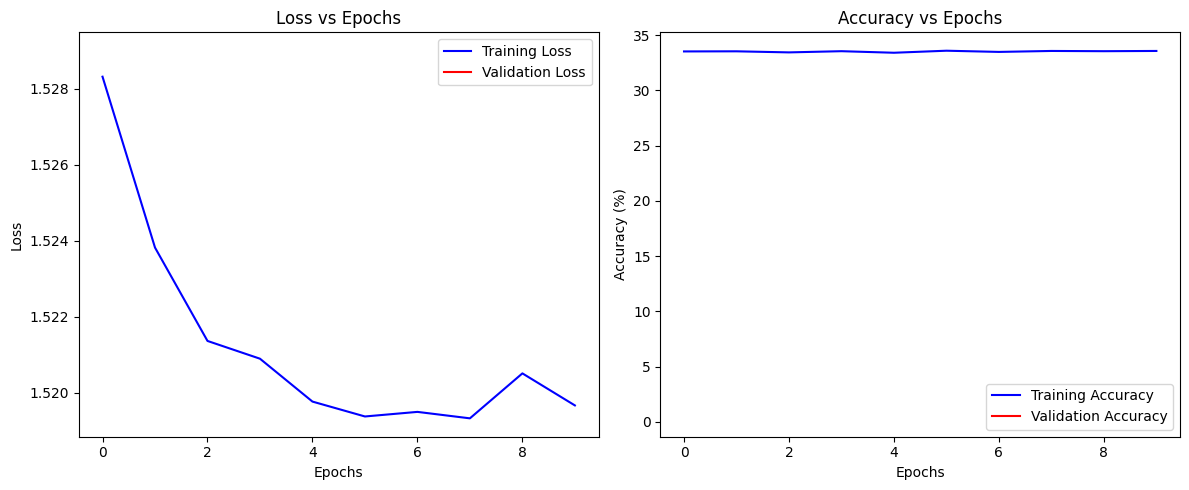

In [116]:
model_trainer.plot_results(train_results)